In [1]:
import re
from unidecode import unidecode
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy.cluster.hierarchy as sch

In [3]:
stop_words = [
    r"S\.?A\.? *DE\.? *C\.?V\.?",
    r"S\.? *DE\.? *R\.?L\.? *DE *C\.?V\.?",
    r"S\.?A\.?P\.?I\.? *DE\.? *C\.?V\.?",
    r"S\.?A\.?B\.? *DE\.? *C\.?V\.?",
    r"S\.? *DE\.? *R\.?L\.?",
    r"\bL\.? *T\.? *D\.?\b",
    r"\bS\.? *A\.?\b",
    r"\bR\.? *L\.?\b",
    r"\bC\.? *V\.?\b",
    r"\bS\.? *C\.?\b",
    r"\bS\.? *C\.? *L\.?",
    r"\bS\.?A\.?P\.?I\.?\b",
    r"S\.A\.S\.?"]

In [4]:
def norm(x):
    for word in stop_words:
        x = re.sub(word, "", x)
    x = x.replace(".", "")
    x = x.replace(",", "")
    return unidecode(x.strip().lower())

In [5]:
cnts = pd.read_csv("../../data/pre-process/contratos_4.csv", parse_dates=['start_date'])

cnts['year'] = cnts.start_date.dt.year

cnts = cnts.dropna(subset=['usupplier', 'ubuyer'])

cnts_slevel = cnts[cnts.gvmnt_level!='F']

cnts = cnts[cnts.gvmnt_level=='F']

In [6]:
cnts['normed'] = cnts['supplier'].apply(norm)

parts = pd.read_json("../../data/tables/s3-particulares-sfp.json")
parts['year'] = pd.to_datetime(parts.fechaCaptura).dt.year.astype(int)
parts = parts[['nombreRazonSocial', 'year']]

parts['normed'] = parts['nombreRazonSocial'].apply(norm)

# Sanctioned suppliers

In [7]:
s = set(cnts['normed'].unique()) & set(parts['normed'].unique())

In [8]:
cnts['sanctioned'] = 0

In [9]:
cnts.loc[cnts.normed.isin(s), 'sanctioned'] = 1

# Fake companies

In [10]:
fantasmas = pd.read_csv("../../data/tables/fantasmas.csv", delimiter="\n", names=['supplier'])

fantasmas['normed'] = fantasmas['supplier'].apply(norm)

s2 = set(cnts['normed'].unique()) & set(fantasmas['normed'].unique())

cnts.loc[cnts.normed.isin(s2), 'sanctioned'] = 1

# Disapearing suppliers in 2019

In [11]:
supplier_18 = cnts[cnts['year']==2018].groupby('usupplier').size().rename("N").reset_index()

s18 = set(supplier_18[supplier_18.N >= supplier_18.N.mean()]['usupplier'].unique())

s19 = set(cnts[cnts.year==2019]['usupplier'].unique())

cnts['unstable'] = 0
cnts.loc[cnts.usupplier.isin(s18 - s19), 'unstable'] = 1

# Persistence of sanctioned companies

In [12]:
def jaccard_index(x):
    union = len(x[0] | x[1])
    intersection = len(x[0] & x[1])
    
    return intersection / union

In [13]:
def yearly_comparison(df, year_1, year_2, min_cnts=5, max_cnts=None):
    
    cnts_1 = df[df['year']==year_1]
    cnts_2 = df[df['year']==year_2]

    buyers = set(cnts_1.ubuyer.unique()) & set(cnts_2.ubuyer.unique())

    B1 = cnts_1[cnts_1.ubuyer.isin(buyers)].groupby('ubuyer').usupplier.apply(set).rename("S1").reset_index()
    B1 = B1.drop_duplicates(subset='ubuyer')
    B1['N1'] = B1['S1'].apply(len)
    B2 = cnts_2[cnts_2.ubuyer.isin(buyers)].groupby('ubuyer').usupplier.apply(set).rename("S2").reset_index()
    B2 = B2.drop_duplicates(subset='ubuyer')
    B2['N2'] = B2['S2'].apply(len)
    B = pd.merge(B1, B2, on='ubuyer', how='left')
    if max_cnts:
        B = B[(B.N1 >= min_cnts) & (B.N2 >= min_cnts) & (B.N1 <= max_cnts) & (B.N2 <= max_cnts)]
    else:
        B = B[(B.N1 >= min_cnts) & (B.N2 >= min_cnts)]

    B['Persistence'] = B[['S1', 'S2']].apply(jaccard_index, axis=1)

    return B

In [14]:
B_17 = yearly_comparison(cnts, 2017, 2018)

B_18 = yearly_comparison(cnts, 2018, 2019)

In [15]:
B_17['Years'] = '17-18'
B_18['Years'] = '18-19'

In [16]:
B = pd.concat([B_17, B_18])

In [17]:
B.groupby('Years').Persistence.mean()

Years
17-18    0.328070
18-19    0.263294
Name: Persistence, dtype: float64

In [18]:
D = B_17.merge(B_18, how='left', on='ubuyer', suffixes=['_17', '_18'])

In [19]:
D['Diff'] = D['Persistence_18'] - D['Persistence_17']

In [20]:
diff_buyers = D[D.Diff <= D.Diff.mean() - 2 * D.Diff.std()]['ubuyer'].unique()

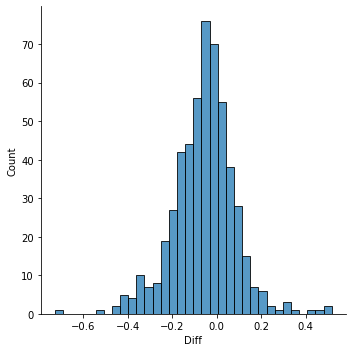

In [21]:
sns.displot(D, x="Diff")

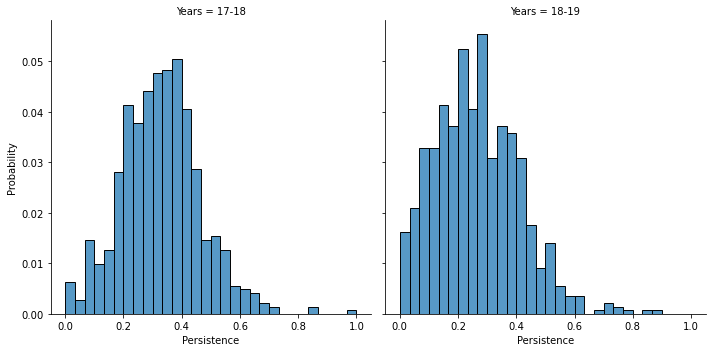

In [22]:
sns.displot(B, x="Persistence", col="Years", stat="probability")

In [23]:
cnts_18 = cnts[(cnts.year==2018) & (cnts.ubuyer.isin(diff_buyers))]
cnts_19 = cnts[(cnts.year==2019) & (cnts.ubuyer.isin(diff_buyers))]

## Loss of suppliers

In [24]:
cnts = pd.merge(cnts,
                cnts[cnts.year==2018].groupby('ubuyer').size().rename('N').reset_index(),
                how="left")

In [25]:
s18 = cnts[(cnts.year==2018) & (cnts.N >= 5)].groupby('ubuyer').usupplier.apply(set).rename('set_18').reset_index()
s19 = cnts[(cnts.year==2019) & (cnts.N >= 5)].groupby('ubuyer').usupplier.apply(set).rename('set_19').reset_index()

In [26]:
s = s18.merge(s19)

In [27]:
s['loss'] = (s['set_18'] - s['set_19']).apply(len)

In [28]:
disapear_sup = set(cnts_18.usupplier.unique()) - set(cnts_19.usupplier.unique())

In [29]:
np.random.seed(42)

In [30]:
cnts_rand = cnts[(~cnts.ubuyer.isin(diff_buyers)) & (cnts.year.isin([2018, 2019])) & (cnts.N >=5)]

In [31]:
data = []
for i in range(1000):
    ran = np.random.randint(0, cnts_rand.shape[0], len(diff_buyers))
    tmp = cnts_rand.iloc[ran]
    tmp_18 = tmp[tmp.year==2018]
    tmp_19 = tmp[tmp.year==2019]
    sup = len(set(tmp_18.usupplier.unique()) - set(tmp_19.usupplier.unique()))
    data.append(sup)

In [32]:
len(disapear_sup)

1126

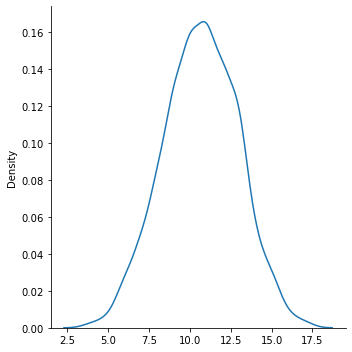

In [33]:
sns.displot(data, kind="kde")

## Gain of suppliers

In [34]:
s['gain'] = (s['set_19'] - s['set_18']).apply(len)

In [35]:
s['diff'] = s['gain'] - s['loss']

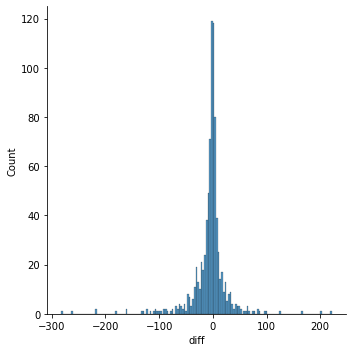

In [36]:
sns.displot(s, x='diff')

In [37]:
gain_sup = set(cnts_19.usupplier.unique()) - set(cnts_18.usupplier.unique())

In [38]:
data_gain = []
for i in range(1000):
    ran = np.random.randint(0, cnts_rand.shape[0], len(diff_buyers))
    tmp = cnts_rand.iloc[ran]
    tmp_18 = tmp[tmp.year==2018]
    tmp_19 = tmp[tmp.year==2019]
    s = len(set(tmp_19.usupplier.unique()) - set(tmp_18.usupplier.unique()))
    data_gain.append(s)

In [39]:
len(gain_sup)

350

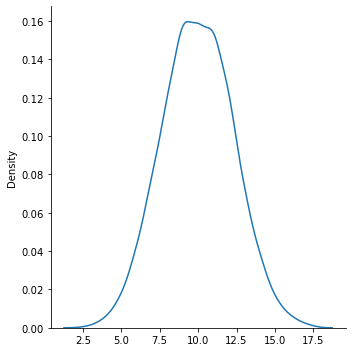

In [40]:
sns.displot(data_gain, kind="kde")

# Cluster

## Sanctioned

In [106]:
usupp_san = cnts[cnts.sanctioned==1].usupplier.unique()

In [107]:
usupp = cnts.groupby('usupplier').size().rename('N').reset_index()
usupp = usupp[usupp.usupplier.isin(usupp_san)]
#usupp = usupp[usupp.N >= 5]

nweeks = int((pd.Timestamp('2019-12-31') - pd.Timestamp('2011-01-01')).days / 30)

In [108]:
time_points = cnts[cnts.usupplier.isin(usupp.usupplier.unique())].groupby(
    'usupplier').start_date.apply(lambda x: sorted(list(x))).rename('window').reset_index()

time_points = dict(zip(time_points['usupplier'], time_points['window']))

In [109]:
M = np.zeros((len(time_points), nweeks + 1))

In [110]:
start = pd.Timestamp('2011-01-01')
for i, tp in enumerate(time_points):
    for t in time_points[tp]:
        j = int((t - start).days / 30)
        M[i][j] = 1

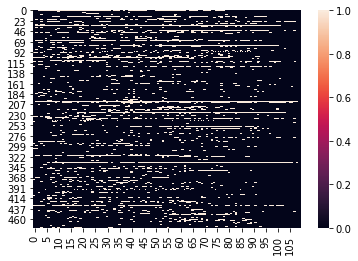

In [111]:
ax = sns.heatmap(M, vmin=0, vmax=1)

#plt.savefig('../figures/monthly_distribution_suppliers.png', dpi=300)

## Clustering

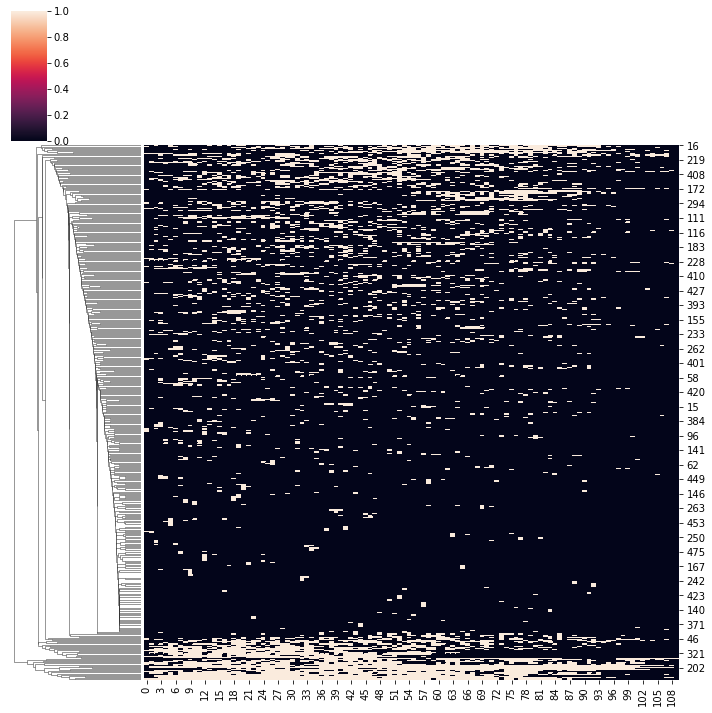

In [112]:
sns.clustermap(M, col_cluster=False)

## Unstable

In [93]:
usupp_san = cnts[cnts.unstable==1].usupplier.unique()

In [94]:
usupp = cnts.groupby('usupplier').size().rename('N').reset_index()
usupp = usupp[usupp.usupplier.isin(usupp_san)]
#usupp = usupp[usupp.N >= 5]

nweeks = int((pd.Timestamp('2019-12-31') - pd.Timestamp('2011-01-01')).days / 30)

In [95]:
time_points = cnts[cnts.usupplier.isin(usupp.usupplier.unique())].groupby(
    'usupplier').start_date.apply(lambda x: sorted(list(x))).rename('window').reset_index()

time_points = dict(zip(time_points['usupplier'], time_points['window']))

In [96]:
M = np.zeros((len(time_points), nweeks + 1))

In [97]:
start = pd.Timestamp('2011-01-01')
for i, tp in enumerate(time_points):
    for t in time_points[tp]:
        j = int((t - start).days / 30)
        M[i][j] = 1

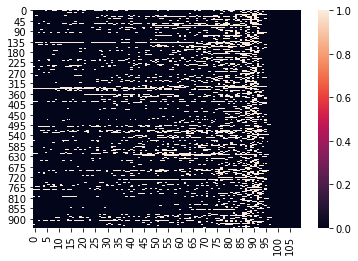

In [98]:
ax = sns.heatmap(M, vmin=0, vmax=1)

#plt.savefig('../figures/monthly_distribution_suppliers.png', dpi=300)

## Clustering

In [99]:
d = sch.distance.pdist(M)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

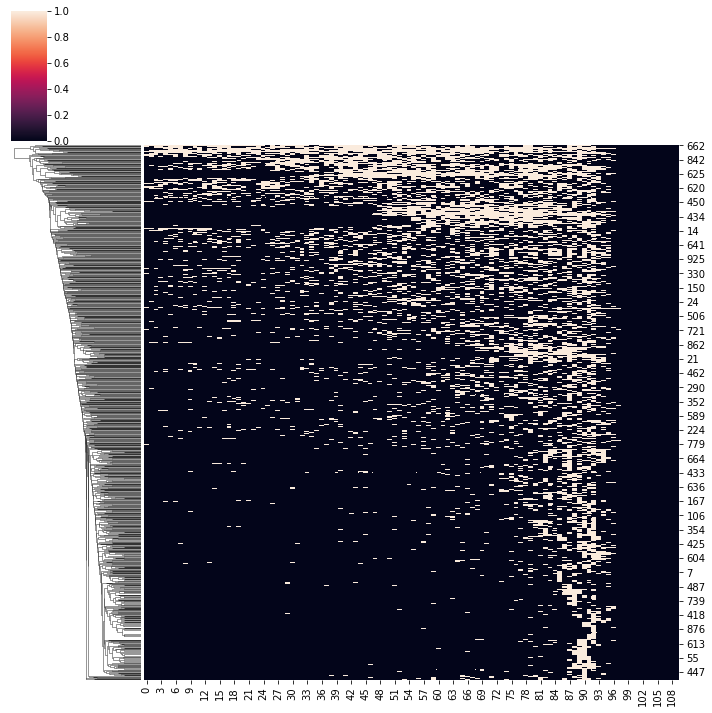

In [100]:
sns.clustermap(M, col_cluster=False)

In [101]:
usupp = cnts.groupby('usupplier').size().rename('N').reset_index()
usupp = usupp[usupp.usupplier.isin(disapear_sup)]
#usupp = usupp[usupp.N >= 5]

nweeks = int((pd.Timestamp('2019-12-31') - pd.Timestamp('2011-01-01')).days / 30)

In [102]:
time_points = cnts[cnts.usupplier.isin(usupp.usupplier.unique())].groupby(
    'usupplier').start_date.apply(lambda x: sorted(list(x))).rename('window').reset_index()

time_points = dict(zip(time_points['usupplier'], time_points['window']))

In [103]:
M = np.zeros((len(time_points), nweeks + 1))

In [104]:
start = pd.Timestamp('2011-01-01')
for i, tp in enumerate(time_points):
    for t in time_points[tp]:
        j = int((t - start).days / 30)
        M[i][j] = 1

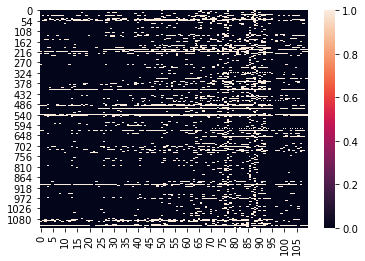

In [105]:
ax = sns.heatmap(M, vmin=0, vmax=1)

#plt.savefig('../figures/monthly_distribution_suppliers.png', dpi=300)

## Clustering

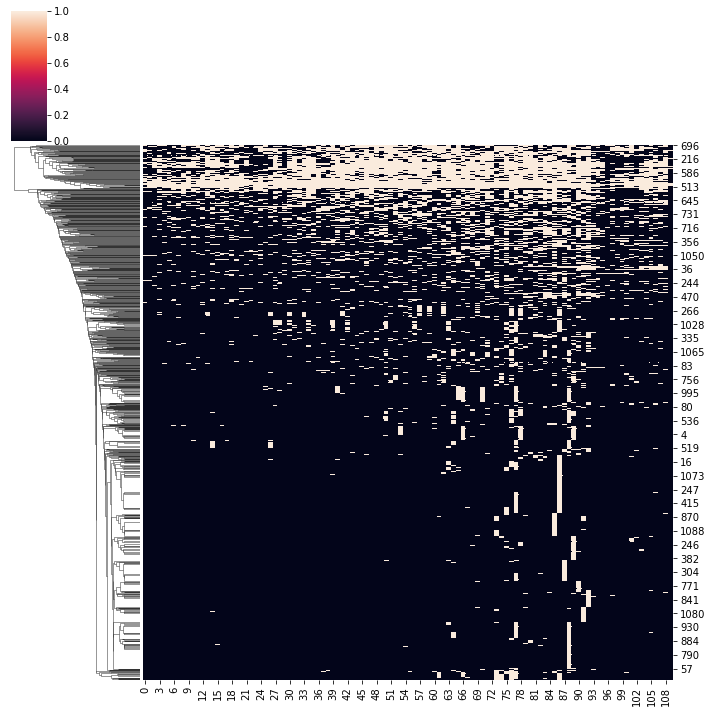

In [89]:
sns.clustermap(M, col_cluster=False)